# 1D Wave Equation Modeling Using PINNs (2-layer Velocity Medium)
- The goal of this notebook is to use a Physics-Informed Neural Net (PINN) to predict the seismic wavefield generated by some (given) initial conditions in a 1D acoustic isotropic medium compsed of **two homogeneous layers** 
- In this example, we parametrize the 2-layer velocity model $v_k(x)$ with a sharpness parameter $k$, which is an input of the Neural Net used to predict the pressure field inside the domain of interest. The velocity values of the two homogeneous are given. 

## Outline
- We create a neural net $N$ which takes into input the position $x$, the time $t$, and **the velocity contrast sharpness**, $k$. The output is the acoustic pressure $p(x,t)$ at this location/time: 

$$N: \; x,t,k \mapsto p(x,t,k)$$

- We train the neural net with k ranging from 1 to 10. We conduct inference for k ranging from 1 to 100 
- We start with some initial conditions and we enforce a boundary condition on the 1D modeling domain: 
    1. Two initial conditions on the pressure field itself and on its time derivative
    $$ p(x,t=0) = sin(x) $$ and $$\frac{\partial p(x,t)}{\partial t}|_{t=0} = sin(x),$$ for all $x \in [0, L]$, where $L$ is the length of the domain.   
    2. One boundary condition 
    $$p(x,t) = 0,$$ for all $t$ and $x\in \{0,L\}$.
    3. One constraint enforcing the pressure field to satisfy the wave-equation inside the 1D modeling domain:
        $$\frac{1}{v_k(x)^2}\frac{\partial^2 p(x,t)}{\partial t^2} - \frac{\partial^2 p(x,t)}{\partial x^2} = 0,$$ for all $x \in [0,L]$ and $t \in [0, 2L].$ 
- For the training stage of the PINN, we add these four constraints  
- In this notebook, we compare the **PINN solution** with numercial solution obtained using a **finite-difference (FD)** scheme (the analytical solution for this case is not available)

## Finite-difference solution

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
################## PINN solution ##################
L = float(np.pi)
x = np.arange(0, L, 0.04)
t = np.arange(0, 2*L, 0.04)
k = np.arange(1, 10, 2)
# print("k: ", k)
nx = x.shape[0]
nt = t.shape[0]
nk = k.shape[0]
vel = np.zeros((nk,nx))
for ik in range(nk):
    vel[ik,:] = 1.0 + 1.0 / (1.0 + np.exp(-2*k[ik]*(x-1.5)))

X, T, K = np.meshgrid(x, t, k)

In [3]:
################## FD solution ##################
# Sampling
dx = 0.01
dt = 0.001

# Boundaries
L = float(np.pi)
x0 = 0
x1 = np.pi
t0 = 0
t1 = 2*np.pi
fmax = 1.0/(2*np.pi)
s = dt*dt/(dx*dx)

# Generate 1D mesh
x_fd = np.arange(x0, x1, dx)
t_fd = np.arange(t0, t1, dt)
k_fd = k
nx_fd = x_fd.shape[0]
nt_fd = t_fd.shape[0]
nk_fd = k_fd.shape[0]
v_fd = np.zeros((nk_fd,nx_fd))
for ik in range(nk_fd):
    v_fd[ik,:] = 1.0 + 1.0 / (1.0 + np.exp(-2*k_fd[ik]*(x_fd-1.5)))

# FD stability/dispersion
courant = v_fd.max()*dt/dx
disp = v_fd.min()/(dt*fmax)
print("Courant:" , courant)
print("Dispersion:" , disp)

## Finite-difference solution
u_fd = np.zeros((nk_fd, nt_fd, nx_fd))

# Initial conditions
u_fd[:,0,:] = np.sin(x_fd)
u_fd[:,1,:] = np.sin(x_fd)*(dt+1)   

# FD scheme 
for it in range(2,nt_fd,1):
    u_fd[:,it,2:nx_fd-1] = 2*(1-s*v_fd[:,2:nx_fd-1]*v_fd[:,2:nx_fd-1])*u_fd[:,it-1,2:nx_fd-1] - u_fd[:,it-2,2:nx_fd-1] + s*v_fd[:,2:nx_fd-1]*v_fd[:,2:nx_fd-1]*(u_fd[:,it-1,3:nx_fd]+u_fd[:,it-1,1:nx_fd-2]) 
                   
# Subsample FD solution
u_fd_sub = u_fd[:,0::40,0::4]
x_fd_sub = x_fd[0::4]
t_fd_sub = t_fd[0::40]

print("--- Done ---")

Courant: 0.19999999999998486
Dispersion: 6283.185307191396
--- Done ---


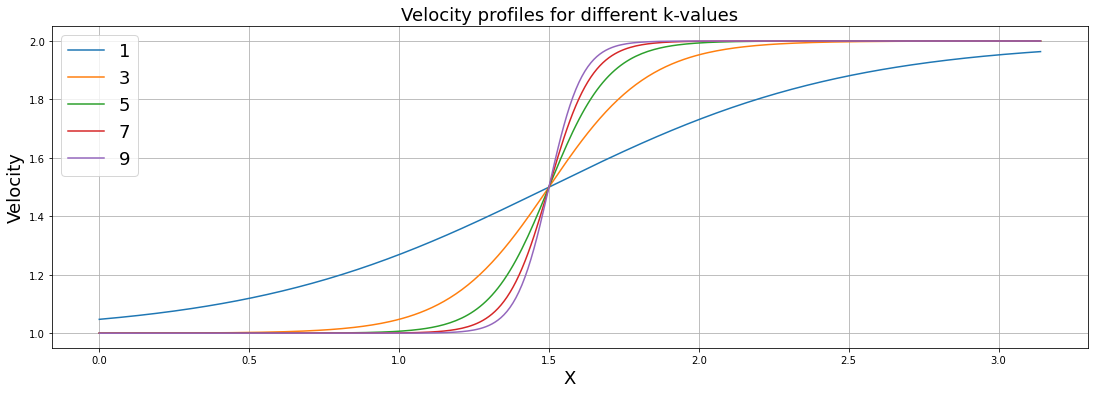

In [4]:
# Plot different velocity profiles as a function of k
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# FD solution
for ik in range(nk_fd):
    img0 = axs.plot(x_fd, v_fd[ik,:], label=str(k_fd[ik]))
    plt.rc('legend', fontsize=18)
plt.tight_layout()
axs.grid()
axs.set_xlabel('X', fontsize=18)
axs.set_ylabel('Velocity', fontsize=18)
axs.set_title('Velocity profiles for different k-values', fontsize=18)
axs.legend()

# Save figure
plt.savefig("we-fwd-1d-vel-k-profiles.png")


## PINN solution
Modify the file ``problem.py`` and train the PINN for k ranging from 1 to 10. Then, load the solution and compare the predicted pressure wavefield with the finite-difference solution for different values of $k$ (even outside the training range)

In [5]:
import training.stage2.infer as infer_stage1

# Display information on inferencer
infer_stage1.info

# Predicted solutions
u1 = infer_stage1.infer(x=X, t=T, k=K)['u']
u1 = u1.reshape(X.shape)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plotting sampled points for training

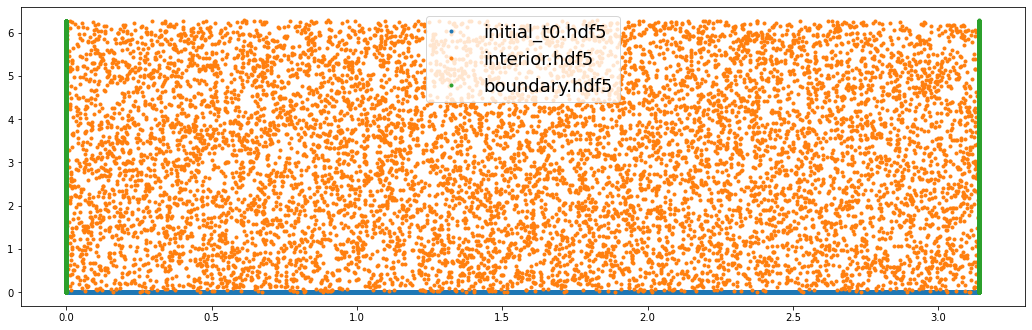

In [6]:
# Plot sampled points for training
import os
import h5py

dpath = 'training/stage1/samples/'
n=10000 # number of points from each sub-domain
dd={}
for fname in reversed(os.listdir(dpath)):
    with h5py.File(dpath+fname) as f:
        idx=np.random.choice(np.arange(f['x'].shape[0]), size=n)
        idx=np.sort(idx)
        plt.plot(f['x'][:][idx], f['t'][:][idx], '.', label=fname)
        dd[fname] = {k:f[k][:] for k in f.keys()}
        
plt.legend()

# Save figure
plt.savefig("we-fwd-1d-vel-k9-sample.png")

k:  7
k shape:  (5,)


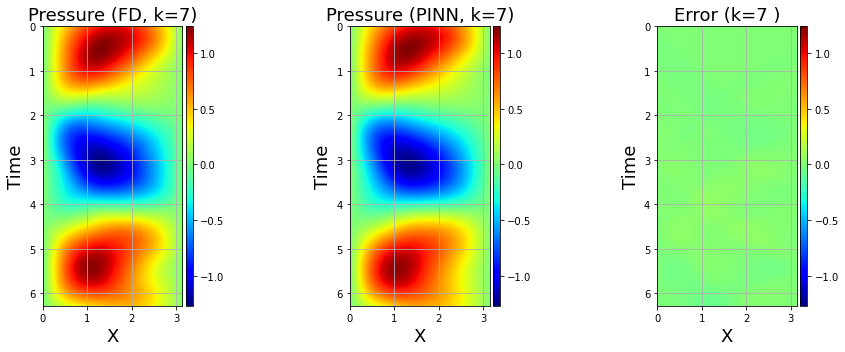

In [7]:
################## Plotting with velocity used for training ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Select velocity
ivel = 3
print("k: ", k_fd[ivel])
print("k shape: ", k_fd.shape)

# FD solution
img0 = axs[0].imshow(u_fd_sub[ivel,:,:], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Time', fontsize=18)
axs[0].set_title('Pressure (FD, k=' + str(k_fd[ivel]) + ')', fontsize=18)
axs[0].grid()
plt.tight_layout()

# PINN solution
img1 = axs[1].imshow(u1[:,:,ivel], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img1, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Time', fontsize=18)
axs[1].set_title('Pressure (PINN, k=' + str(k_fd[ivel]) + ')', fontsize=18)
axs[1].grid()
plt.tight_layout()

# Error
img4 = axs[2].imshow(u_fd_sub[ivel,:,:]-u1[:,:,ivel], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img4, cax=cax)
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Time', fontsize=18)
axs[2].set_title('Error (k=' + str(k_fd[ivel]) + ' )', fontsize=18)
axs[2].grid()
plt.tight_layout()

# Error
# img4 = axs[3].imshow(u_fd_sub[ivel,:,:]-u1[:,:,ivel], cmap='jet', vmin=-0.1, vmax=0.1, extent=(0, L, 0, 2*L))
# divider = make_axes_locatable(axs[3])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(img4, cax=cax)
# axs[3].set_xlabel('X')
# axs[3].set_ylabel('Time')
# axs[3].set_title('Error (low clipping)')
# axs[3].grid()
# plt.tight_layout()

# Save figure
plt.savefig("we-fwd-1d-vel-k9-pressure.png")

shape:  (6284,)
u_fd_sub:  (5, 158, 79)
u1:  (158, 79, 5)
t_fd_sub:  3.6
k:  3
k shape:  (5,)


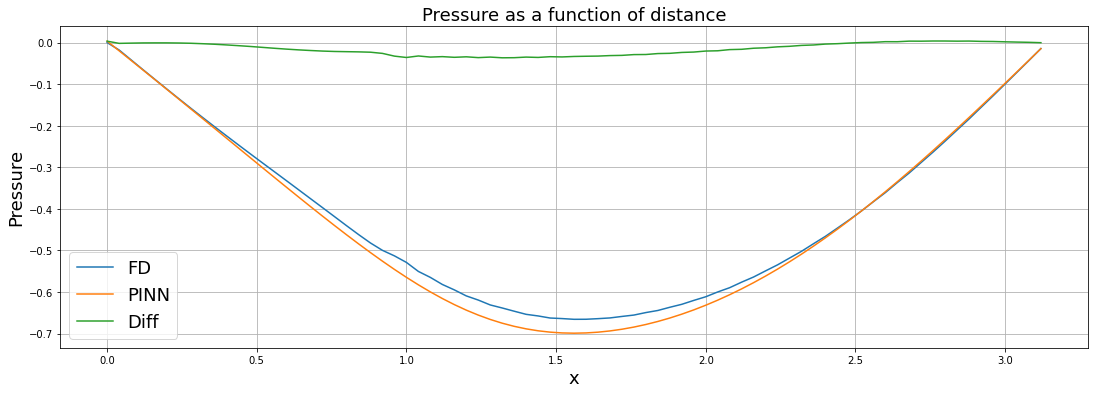

In [8]:
####### 1D plots at constant time #######
ivel = 1 # Velocity value
itime = 90 # Time 

######## Display info ########
print("shape: ", t_fd.shape)
print("u_fd_sub: ", u_fd_sub.shape)
print("u1: ", u1.shape)
print("t_fd_sub: ", t_fd_sub[itime])
print("k: ", k_fd[ivel])
print("k shape: ", k_fd.shape)
##############################

p_fd = u_fd_sub[ivel,itime,:] # FD solution
p1 = u1[itime,:,ivel]

################## Plotting ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# FD solution
img0 = axs.plot(x_fd_sub, p_fd, label="FD")
img0 = axs.plot(x, p1, label="PINN")
img0 = axs.plot(x, p1-p_fd, label="Diff")
plt.tight_layout()
axs.grid()
axs.set_xlabel('x', fontsize=18)
axs.set_ylabel('Pressure', fontsize=18)
axs.set_title('Pressure as a function of distance', fontsize=18)
axs.legend()

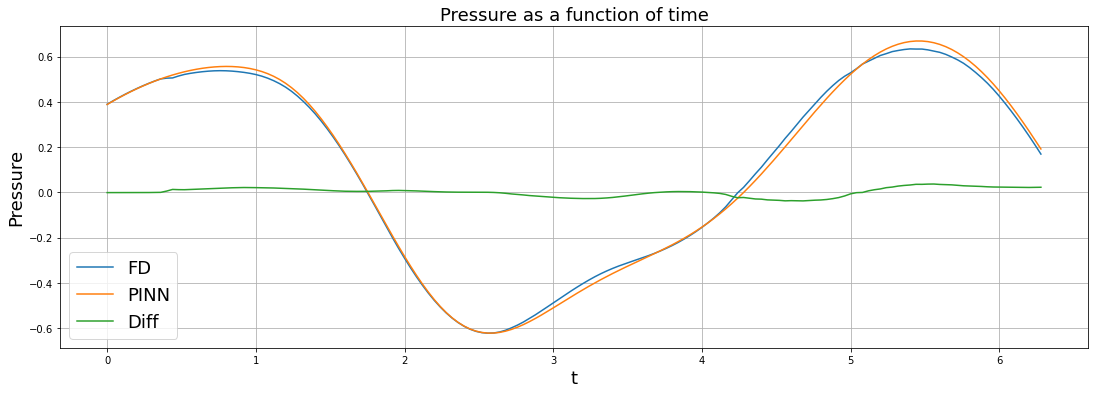

In [9]:
####### 1D plots at constant position #######
ivel = 2 # Velocity value
ipos = 10 # Time 

p_fd = u_fd_sub[ivel,:,ipos] # FD solution
p1 = u1[:,ipos,ivel]

################## Plotting ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# Solutions
img0 = axs.plot(t_fd_sub, p_fd, label="FD")
img0 = axs.plot(t, p1, label="PINN")
img0 = axs.plot(t, p1-p_fd, label="Diff")
plt.tight_layout()
axs.grid()
axs.set_xlabel('t', fontsize=18)
axs.set_ylabel('Pressure', fontsize=18)
axs.set_title('Pressure as a function of time', fontsize=18)
axs.legend()

